In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import plotting
#from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, nice_violinplot, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [4]:
from data_loading import (load_annotated_TFiso1_collection,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

In [5]:
# sns.set(**PAPER_PRESET)
# fontsize = PAPER_FONTSIZE

In [6]:
np.random.seed(2023)

## functions

In [7]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [8]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

## variables

In [9]:
dn_cats_f = "../data/processed/DN_cats_Joung.tsv"

In [10]:
pal = {"ref": sns.color_palette("Set2")[0],
       "ref-v-ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
       "both": sns.color_palette("Set2")[3]}

## 1. import data

In [11]:
dn_cats = pd.read_table(dn_cats_f)
dn_cats["dn_cat"].fillna("NA", inplace=True)
dn_cats.dn_cat.value_counts()

NA        278
ref       246
DN         93
rewire     74
likely      2
Name: dn_cat, dtype: int64

In [12]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [13]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [14]:
metadata_gtex_dummy = pd.read_table("../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [15]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


## 2. down-sample gtex using the same dummy metadata as fig 1

In [16]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

## 3. calculate expression ratios (copy-pasted from luke's code in expr_data.ipynb)

In [17]:
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [18]:
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [19]:
df_gtex.loc[:,metadata_gtex_dummy.index].shape

(1376, 313)

In [20]:
df_gtex.shape

(1376, 2485)

In [21]:
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

## 3. calculate tissue-specificity

this is currently across all individual samples for genes but not for isos

In [22]:
gene_dev_nonan_taus, gene_dev_nan_taus, gene_dev_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_dev_nan_taus[0:5]

array([0.72426949, 0.79449918, 0.84426404, 0.87460237, 0.91855192])

In [23]:
gene_gtex_nonan_taus, gene_gtex_nan_taus, gene_gtex_array_max = calculate_tau(per_gene_gtex.drop_duplicates())
gene_gtex_nan_taus[0:5]

array([0.77681209, 0.94432032, 0.95815292, 0.93717632, 0.79040074])

In [24]:
gene_gtex_ds_nonan_taus, gene_gtex_ds_nan_taus, gene_gtex_ds_array_max = calculate_tau(per_gene_gtex_ds.drop_duplicates())
gene_gtex_ds_nan_taus[0:5]

array([0.68483818, 0.91906737, 0.93164349, 0.73204809, 0.79405019])

In [25]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["dev_tau"] = gene_dev_nan_taus
gene_taus["gtex_tau"] = gene_gtex_nan_taus
gene_taus["gtex_ds_tau"] = gene_gtex_ds_nan_taus
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,dev_tau,gtex_tau,gtex_ds_tau,gene_name
262,ZNF419|1/4|02H10 ZNF419-201,0.604219,0.933575,0.783097,ZNF419
13,DDIT3|1/2|05B05 DDIT3-204_DDIT3-205,0.992327,0.995127,0.973595,DDIT3
295,ZNF75A|1/2|11B06 ZNF75A-205_ZNF75A-210,0.782886,0.944171,0.862702,ZNF75A
307,ZSCAN32|1/5|05B06 ZSCAN32-203,0.788543,0.863190,0.733176,ZSCAN32
83,LHX9|1/3|06C10 LHX9-201,0.956154,0.985383,0.979185,LHX9


## 4. join with DN categories

In [26]:
indiv_cols = f_dev.columns
dev_ratios = f_dev.reset_index()

dev_ratios["clone_acc"] = dev_ratios["UID"].str.split(" ", expand=True)[0]
dev_ratios.head()

,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,testis 16,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult,clone_acc
0,AEBP2|2/3|05F03 nomatch,8.770825,5.460097,3.748771,3.188589,0.440583,3.743192,4.894554e+00,5.178928,12.198085,...,1.323679,4.141163,22.014329,1.928627,18.013990,0.000000,4.813526,2.366820,3.044304,AEBP2|2/3|05F03
1,AEBP2|3/3|05E07 nomatch,1.128610,0.492277,8.731672,0.803170,0.000000,0.000000,0.000000e+00,0.000000,0.440492,...,0.678523,0.000000,1.916075,0.000000,0.000000,0.000000,3.721128,0.542803,0.000000,AEBP2|3/3|05E07
2,ARNT2|1/6|08C12 ARNT2-201,94.168553,98.542376,96.466911,98.552748,87.660480,98.939268,9.904231e+01,96.300384,96.502246,...,97.224681,100.000000,100.000000,48.332268,56.638580,43.556409,96.666964,100.000000,58.799880,ARNT2|1/6|08C12
3,ARNT2|2/6|09E01 nomatch,3.216348,0.869466,3.533089,0.456195,0.000000,0.290142,2.459982e-01,1.376733,0.794998,...,0.000000,0.000000,0.000000,0.000000,1.729682,0.000000,0.150583,0.000000,0.174124,ARNT2|2/6|09E01
4,ARNT2|3/6|10D11 ARNT2-209,0.000000,0.000000,0.000000,0.000000,11.955511,0.000000,2.650723e-10,0.585737,0.000000,...,1.131732,0.000000,0.000000,46.973894,0.000000,36.444243,0.003060,0.000000,27.707265,ARNT2|3/6|10D11


In [27]:
indiv_cols = f_gtex.columns
gtex_ratios = f_gtex.reset_index()

gtex_ratios["clone_acc"] = gtex_ratios["UID"].str.split(" ", expand=True)[0]

In [28]:
indiv_cols = f_gtex_downsample.columns
gtex_ds_ratios = f_gtex_downsample.reset_index()

gtex_ds_ratios["clone_acc"] = gtex_ds_ratios["UID"].str.split(" ", expand=True)[0]

In [29]:
dev_ratios = dev_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
gtex_ratios = gtex_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
gtex_ds_ratios = gtex_ds_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
print(len(dev_ratios))
print(len(gtex_ratios))
print(len(gtex_ds_ratios))

692
692
692


## 5. calculate co-expression

In [30]:
# def count_coex(row, thresh):
#     tot = 0
#     for col in indiv_cols:
#         ref_val = row["%s_ref" % col]
#         alt_val = row["%s_alt" % col]
#         if ref_val > thresh and alt_val > thresh:
#             tot += 1
#     return tot

In [31]:
# ratios_ref = ratios[ratios["dn_cat"] == "ref"]
# ratios_alt = ratios[ratios["dn_cat"] != "ref"]

# ratios_v = ratios_ref.merge(ratios_alt, on="gene_name", suffixes=("_ref", "_alt"))
# ratios_v["num_coex"] = ratios_v.apply(count_coex, thresh=0.1, axis=1)
# ratios_v["num_coex"].fillna(0, inplace=True)
# ratios_v.sample(5)

In [32]:
# # do the null test: randomly sample 2 refs 100 times and do the same thing
# null = pd.DataFrame()
# for i in range(100):
#     ref1 = ratios_ref.sample()
#     ref2 = ratios_ref.sample()
    
#     ref1["tmp_gene"] = "tmp_gene"
#     ref2["tmp_gene"] = "tmp_gene"
    
#     mrg = ref1.merge(ref2, on="tmp_gene", suffixes=("_ref", "_alt"))
#     mrg["gene_name"] = mrg["gene_name_ref"] + "-v-" + mrg["gene_name_alt"]
#     mrg["dn_cat_alt"] = "ref-v-ref"
#     mrg["num_coex"] = mrg.apply(count_coex, thresh=0.1, axis=1)
#     null = null.append(mrg)

# null.sample(5)

In [33]:
# ratios_coex = ratios_v[["gene_name", "tf1p0_id_ref", 
#                         "tf1p0_id_alt", "dn_cat_alt", 
#                         "num_coex", "neglog_diff_pval_ref", 
#                         "neglog_diff_pval_alt"]].append(null[["gene_name", "tf1p0_id_ref", 
#                                                               "tf1p0_id_alt", "dn_cat_alt", "num_coex",
#                                                               "neglog_diff_pval_ref", "neglog_diff_pval_alt"]])
# ratios_coex.dn_cat_alt.value_counts()

## 6. make some plots

In [34]:
dn_cats = dn_cats.merge(gene_taus, on="gene_name").drop_duplicates()
print(len(dn_cats))
dn_cats.head()

693


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,UID,dev_tau,gtex_tau,gtex_ds_tau
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,TFORF2495-ZBTB18,0.172521,0.002115,0.168074,-0.004946,531.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.955386
1,ZBTB18,C2H2 ZF,ZBTB18|2/2|12E05,False,False,rewire,alt,Genewiz,TFORF2494,ZBTB18,...,TFORF2494-ZBTB18,0.006114,0.003615,0.244046,-0.003313,522.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.955386
2,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,TFORF1217-PRRX1,0.365286,0.000400,0.000021,-0.009730,245.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.858598
3,PRRX1,Homeodomain,PRRX1|1/3|09C07,False,False,NA,alt,Genewiz,TFORF1218,PRRX1,...,TFORF1218-PRRX1,0.006905,0.002594,0.000440,-0.001672,217.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.858598
4,PRRX1,Homeodomain,PRRX1|3/3|09H08,False,False,rewire,alt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.858598


In [35]:
ref_expr = dn_cats.groupby(["gene_name", "family", "dn_cat", "dev_tau",
                            "gtex_tau", "gtex_ds_tau"])["tf1p0_id"].agg("count").reset_index()
ref_expr = ref_expr.pivot(index="gene_name",
                          columns="dn_cat", values="tf1p0_id")
ref_expr.fillna(0, inplace=True)

In [36]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire > 0:
        return "both"
    elif row.DN > 0:
        return "DN"
    elif row.rewire > 0:
        return "rewire"
    elif row.NA > 0:
        return "NA"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.reset_index(inplace=True)
ref_expr = ref_expr.merge(dn_cats[["gene_name", "family", "dev_tau", "gtex_tau", "gtex_ds_tau"]],
                          on="gene_name").drop_duplicates()
print(len(ref_expr))
ref_expr.sample(5)

246


,gene_name,DN,NA,likely,ref,rewire,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
125,GLIS2,0.0,1.0,0.0,1.0,0.0,NA,C2H2 ZF,0.891479,0.926703,0.889402
30,CXXC1,0.0,1.0,0.0,1.0,0.0,NA,CxxC,0.683629,0.728421,0.702076
17,ATF3,0.0,1.0,0.0,1.0,0.0,NA,bZIP,0.974409,0.984790,0.972377
0,AEBP2,0.0,1.0,0.0,1.0,0.0,NA,C2H2 ZF,0.724269,0.776812,0.684838
312,PPARG,0.0,0.0,2.0,1.0,1.0,rewire,Nuclear receptor,0.982176,0.997532,0.985807


In [69]:
ref_expr[ref_expr["gene_name"] == "PKNOX1"]

,gene_name,DN,NA,likely,ref,rewire,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
301,PKNOX1,3.0,0.0,0.0,1.0,0.0,DN,Homeodomain,0.740013,0.89221,0.810267


In [39]:
# nice_boxplot(ref_expr, "dev_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
#             [1.04, 1.11, 1.17, 1.02], 0.35, "", ["rewirer", "negative regulator", "both", "NA"], 
#             "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
#             "developmental gene expression\nclassified TF genes", 
#             "../figures/DN_DevTau_Gene_Boxplot.pdf")

In [40]:
# nice_boxplot(ref_expr, "gtex_ds_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
#             [1.05, 1.11, 1.17, 1.02], 0.45, "", ["rewirer", "negative regulator", "both", "NA"], 
#             "gene-level tissue specificity (tau)", False, (0.4, 1.23), 
#             "GTEx gene expression\nclassified TF genes", 
#             "../figures/DN_GTExDsTau_Gene_Boxplot.pdf")

In [42]:
# nice_boxplot(ref_expr, "gtex_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
#             [1.05, 1.11, 1.17, 1.02], 0.45, "", ["rewirer", "negative regulator", "both", "NA"], 
#             "gene-level tissue specificity (tau)", False, (0.4, 1.23), 
#             "GTEx gene expression\nclassified TF genes", 
#             "../figures/DN_GTExTau_Gene_Boxplot.pdf")

In [43]:
def developmental_tissue_expression_plot(gene_name, figsize, ylim, means, cols, fig_suffix):
    locs = [x for x in list(means.index) if x.split("|")[0] == gene_name]
    
    # include isos that aren't cloned
    locs = list(set(locs + [x for x in list(means.index) if x.split(" ")[1][:-4] == gene_name]))
    
    n_isos = len(means.loc[locs])
    palette = sns.color_palette("Spectral", as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[locs, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[locs, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../figures/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

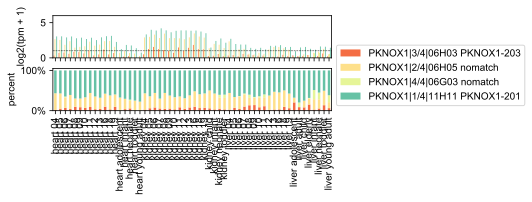

In [44]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (5, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis")

In [45]:
f_dev.loc["PKNOX1|1/4|11H11 PKNOX1-201"].min()

21.730631297352325

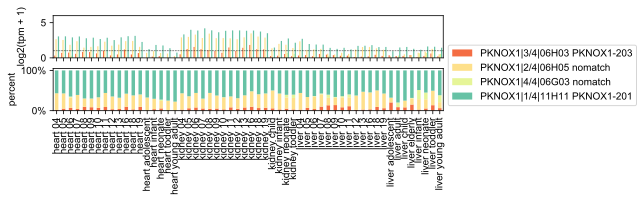

In [46]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (7, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

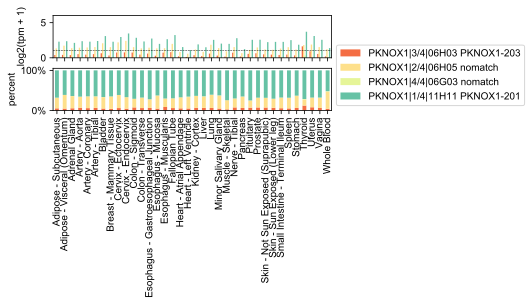

In [47]:
notestis_cols = [x for x in means_gtex.columns if "Testis" not in x]
notestis_cols = [x for x in notestis_cols if "_gtex" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "Ovary" not in x]
notestis_cols = [x for x in notestis_cols if "Brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (5, 1.75), (0, 6), means_gtex, notestis_cols, 
                                     "means_gtex_notestis")

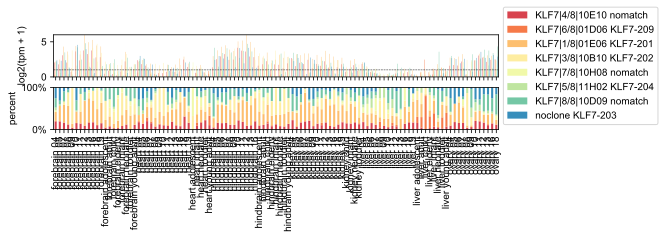

In [48]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
# notestis_cols = [x for x in notestis_cols if "ovary" not in x]
# notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("KLF7", (8, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

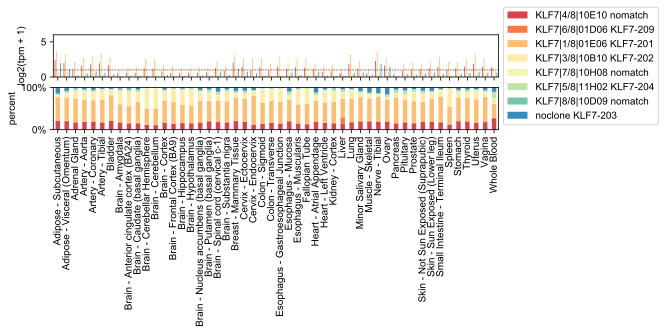

In [49]:
notestis_cols = [x for x in means_gtex.columns if "Testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
# notestis_cols = [x for x in notestis_cols if "ovary" not in x]
# notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("KLF7", (8, 1.75), (0, 6), means_gtex, notestis_cols, 
                                     "means_gtex_notestis_large")

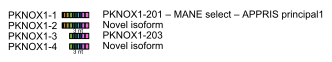

In [50]:
fig, ax = plt.subplots(figsize=(4.5, 0.75))

tfs["PKNOX1"].exon_diagram(ax=ax)

fig.savefig("../figures/PKNOX1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

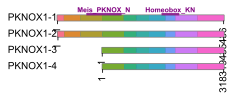

In [51]:
fig, ax = plt.subplots(figsize=(3, 1))

tfs["PKNOX1"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)

fig.savefig("../figures/PKNOX1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

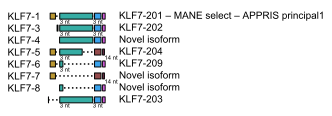

In [52]:
fig, ax = plt.subplots(figsize=(4.5, 1.5))

tfs["KLF7"].exon_diagram(ax=ax)

fig.savefig("../figures/KLF7_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

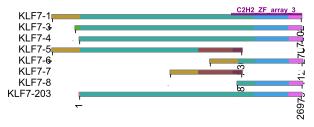

In [53]:
fig, ax = plt.subplots(figsize=(4.5, 1.5))

tfs["KLF7"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)

fig.savefig("../figures/KLF7_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

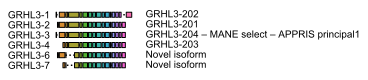

In [54]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs["GRHL3"].exon_diagram(ax=ax)

fig.savefig("../figures/GRHL3_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

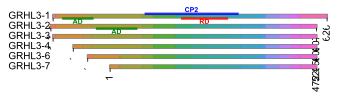

In [55]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs["GRHL3"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)

fig.savefig("../figures/GRHL3_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

## novel isoforms aside

In [56]:
status_map = {}

# only loop through clone collection
for tf in tfs.keys():
    gene = tfs[tf]
    
    try:
        annot_ref = gene.reference_isoform.name
    except:
        annot_ref = "none"
        
    try:
        annot_alt = gene.alternative_isoforms
    except:
        annot_alt = []
        
    for iso in gene.cloned_isoforms:
        if iso.name == annot_ref:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "ref"}
        elif iso.is_novel_isoform():
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "novel"}
        else:
            status_map[iso.clone_acc] = {"gene_name": tf, "status": "alt"}

In [57]:
status_map = pd.DataFrame.from_dict(status_map, orient="index")
status_map

,gene_name,status
ZBTB18|1/2|04E08,ZBTB18,ref
ZBTB18|2/2|12E05,ZBTB18,alt
PRRX1|1/3|09C07,PRRX1,alt
PRRX1|2/3|09F06,PRRX1,ref
PRRX1|3/3|09H08,PRRX1,alt
...,...,...
HDX|2/2|09H10,HDX,novel
ZFY|1/2|06H10,ZFY,novel
ZFY|2/2|06E10,ZFY,novel
HSFY1|1/2|12F03,HSFY1,novel


In [58]:
means_dev["median"] = means_dev.median(axis=1)
means_dev["max"] = means_dev.max(axis=1)

means_gtex_downsample["median"] = means_gtex_downsample.median(axis=1)
means_gtex_downsample["max"] = means_gtex_downsample.max(axis=1)

In [59]:
dev_mm = means_dev[["median", "max"]].reset_index()
gtex_ds_mm = means_gtex_downsample[["median", "max"]].reset_index()

In [60]:
dev_mm["clone_acc"] = dev_mm["UID"].str.split(" ", expand=True)[0]
gtex_ds_mm["clone_acc"] = gtex_ds_mm["UID"].str.split(" ", expand=True)[0]
mm = dev_mm[dev_mm["clone_acc"] != "noclone"].merge(gtex_ds_mm[gtex_ds_mm["clone_acc"] != "noclone"], 
                                                    on="clone_acc", suffixes=("_dev", "_gtex_ds"))
mm.sample(5)

,UID_dev,median_dev,max_dev,clone_acc,UID_gtex_ds,median_gtex_ds,max_gtex_ds
488,TP63|1/3|07F10 TP63-201,0.000000,1.182296,TP63|1/3|07F10,TP63|1/3|07F10 TP63-201,0.096707,2.607445
697,ZNF607|1/2|04H08 nomatch,0.000000,0.986480,ZNF607|1/2|04H08,ZNF607|1/2|04H08 nomatch,0.000000,0.076284
35,DLX1|1/2|07A12 DLX1-203,0.135132,5.608761,DLX1|1/2|07A12,DLX1|1/2|07A12 DLX1-203,0.139673,4.670808
147,HHEX|2/2|05A04 HHEX-202_HHEX-203,2.089175,7.682359,HHEX|2/2|05A04,HHEX|2/2|05A04 HHEX-202_HHEX-203,1.634599,10.782585
216,MAZ|3/3|09D04 MAZ-215,2.911858,5.307986,MAZ|3/3|09D04,MAZ|3/3|09D04 MAZ-215,2.550959,5.939953


In [61]:
status_map = status_map.reset_index()
status_map["clone_acc"] = status_map["index"].str.split(" ", expand=True)[0]

In [62]:
exp_nov = status_map.merge(mm, on="clone_acc")
exp_nov_melt = pd.melt(exp_nov, id_vars=["index", "gene_name", "status", "clone_acc"], value_vars=["median_dev",
                                                                                                   "max_dev",
                                                                                                   "median_gtex_ds",
                                                                                                   "max_gtex_ds"])
exp_nov_melt["measurement"] = exp_nov_melt["variable"].str.split("_", expand=True)[0]

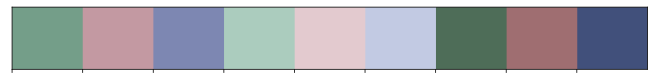

In [63]:
colors = met_brewer.met_brew(name="Monet")
sns.palplot(colors)

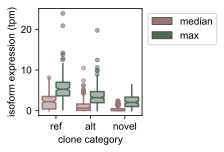

In [68]:
fig = plt.figure(figsize=(3, 2))

exp_nov_melt["value_log2"] = np.log2(exp_nov_melt["value"]+1)
ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

plotting.mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

fig.savefig("../figures/novel_isos.dev_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

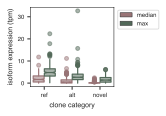

In [160]:
fig = plt.figure(figsize=(2.2, 1.5))

ax = sns.boxplot(data=exp_nov_melt[exp_nov_melt["variable"].str.contains("gtex")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (tpm)")

fig.savefig("../figures/novel_isos.gtex_expr_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [161]:
status_map.status.value_counts()

alt      357
ref      208
novel    191
Name: status, dtype: int64

In [153]:
exp_nov.status.value_counts()

alt      357
ref      208
novel    190
Name: status, dtype: int64

In [166]:
exp_nov.groupby("status")[["median_dev", "max_dev", "median_gtex_ds", "max_gtex_ds"]].agg("mean")

,median_dev,max_dev,median_gtex_ds,max_gtex_ds
status,,,,
alt,1.056301,3.454227,0.939357,3.061528
novel,0.340870,2.230258,0.223223,1.687921
ref,2.216911,5.643448,2.077894,5.174942


In [154]:
exp_nov[exp_nov["median_dev"] >= 1].status.value_counts()

ref      139
alt      137
novel     26
Name: status, dtype: int64

In [155]:
exp_nov[exp_nov["max_dev"] >= 1].status.value_counts()

alt      322
ref      202
novel    143
Name: status, dtype: int64

In [156]:
exp_nov[exp_nov["median_gtex_ds"] >= 1].status.value_counts()

ref      137
alt      129
novel     13
Name: status, dtype: int64

In [157]:
exp_nov[exp_nov["max_gtex_ds"] >= 1].status.value_counts()

alt      304
ref      203
novel    113
Name: status, dtype: int64

In [169]:
exp_nov[exp_nov["status"] == "novel"].sort_values(by="max_dev", ascending=False).head(20)

,index,gene_name,status,clone_acc,UID_dev,median_dev,max_dev,UID_gtex_ds,median_gtex_ds,max_gtex_ds
553,ZNF207|3/4|01G11,ZNF207,novel,ZNF207|3/4|01G11,ZNF207|3/4|01G11 nomatch,2.415743,6.341687,ZNF207|3/4|01G11 nomatch,0.000000,3.774909
174,SOX30|2/2|09C11,SOX30,novel,SOX30|2/2|09C11,SOX30|2/2|09C11 nomatch,0.000000,6.333112,SOX30|2/2|09C11 nomatch,0.000000,6.150915
328,CREM|2/3|10G01,CREM,novel,CREM|2/3|10G01,CREM|2/3|10G01 nomatch,0.658140,6.022916,CREM|2/3|10G01 nomatch,0.025679,5.995451
131,TFDP2|3/4|04B01,TFDP2,novel,TFDP2|3/4|04B01,TFDP2|3/4|04B01 nomatch,1.358309,5.518309,TFDP2|3/4|04B01 nomatch,0.724303,4.683652
542,ZNF688|4/5|01A03,ZNF688,novel,ZNF688|4/5|01A03,ZNF688|4/5|01A03 nomatch,0.780565,5.424667,ZNF688|4/5|01A03 nomatch,2.088060,5.197166
584,SMAD4|1/2|01A02,SMAD4,novel,SMAD4|1/2|01A02,SMAD4|1/2|01A02 nomatch,2.404842,5.223090,SMAD4|1/2|01A02 nomatch,1.648037,4.440653
61,ZNF692|2/3|06B09,ZNF692,novel,ZNF692|2/3|06B09,ZNF692|2/3|06B09 nomatch,0.217214,4.977546,ZNF692|2/3|06B09 nomatch,0.000000,2.239052
388,ZBTB44|6/9|12H02,ZBTB44,novel,ZBTB44|6/9|12H02,ZBTB44|6/9|12H02 nomatch,0.000000,4.959385,ZBTB44|6/9|12H02 nomatch,0.000000,2.445901
233,DMTF1|4/5|04D12,DMTF1,novel,DMTF1|4/5|04D12,DMTF1|4/5|04D12 nomatch,1.850030,4.925544,DMTF1|4/5|04D12 nomatch,0.104278,2.436031
73,PAX8|1/5|07H05,PAX8,novel,PAX8|1/5|07H05,PAX8|1/5|07H05 nomatch,0.000000,4.850805,PAX8|1/5|07H05 nomatch,0.000000,1.774851


In [170]:
f_dev["median"] = f_dev.median(axis=1)
f_dev["max"] = f_dev.max(axis=1)

f_gtex_downsample["median"] = f_gtex_downsample.median(axis=1)
f_gtex_downsample["max"] = f_gtex_downsample.max(axis=1)

In [171]:
dev_mm = f_dev[["median", "max"]].reset_index()
gtex_ds_mm = f_gtex_downsample[["median", "max"]].reset_index()

In [172]:
dev_mm["clone_acc"] = dev_mm["UID"].str.split(" ", expand=True)[0]
gtex_ds_mm["clone_acc"] = gtex_ds_mm["UID"].str.split(" ", expand=True)[0]
mm = dev_mm[dev_mm["clone_acc"] != "noclone"].merge(gtex_ds_mm[gtex_ds_mm["clone_acc"] != "noclone"], 
                                                    on="clone_acc", suffixes=("_f_dev", "_f_gtex_ds"))
mm.sample(5)

,UID_f_dev,median_f_dev,max_f_dev,clone_acc,UID_f_gtex_ds,median_f_gtex_ds,max_f_gtex_ds
230,MEOX1|1/3|08C05 MEOX1-201,50.178989,73.857859,MEOX1|1/3|08C05,MEOX1|1/3|08C05 MEOX1-201,55.950913,89.436450
357,RFX3|2/5|10F10 RFX3-204_RFX3-212,92.302013,99.636412,RFX3|2/5|10F10,RFX3|2/5|10F10 RFX3-204_RFX3-212,89.260833,100.000000
538,ZKSCAN3|2/2|07C05 ZKSCAN3-202,11.350022,50.681538,ZKSCAN3|2/2|07C05,ZKSCAN3|2/2|07C05 ZKSCAN3-202,1.037529,34.536110
38,DLX4|2/3|10A03 DLX4-202,11.175038,39.877584,DLX4|2/3|10A03,DLX4|2/3|10A03 DLX4-202,23.105825,33.710361
516,ZBTB44|6/9|12H02 nomatch,0.000000,37.191132,ZBTB44|6/9|12H02,ZBTB44|6/9|12H02 nomatch,0.000000,19.575548


In [173]:
f_nov = status_map.merge(mm, on="clone_acc")
f_nov_melt = pd.melt(f_nov, id_vars=["index", "gene_name", "status", "clone_acc"], value_vars=["median_f_dev",
                                                                                               "max_f_dev",
                                                                                               "median_f_gtex_ds",
                                                                                               "max_f_gtex_ds"])
f_nov_melt["measurement"] = f_nov_melt["variable"].str.split("_", expand=True)[0]

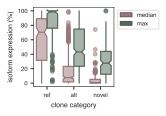

In [174]:
fig = plt.figure(figsize=(2.2, 1.5))

ax = sns.boxplot(data=f_nov_melt[exp_nov_melt["variable"].str.contains("dev")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (%)")

fig.savefig("../figures/novel_isos.dev_ratio_boxplot.pdf", dpi="figure", bbox_inches="tight")

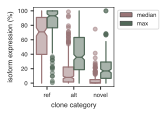

In [175]:
fig = plt.figure(figsize=(2.2, 1.5))

ax = sns.boxplot(data=f_nov_melt[exp_nov_melt["variable"].str.contains("gtex")], 
                 x="status", y="value", hue="measurement", palette={"median": colors[7],
                                                                    "max": colors[6]}, 
                 flierprops={"marker": "o"}, fliersize=4, notch=True)

mimic_r_boxplot(ax)

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("clone category")
ax.set_ylabel("isoform expression (%)")

fig.savefig("../figures/novel_isos.gtex_ratio_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [176]:
f_nov[f_nov["status"] == "novel"].sort_values(by="max_f_dev", ascending=False).head(20)

,index,gene_name,status,clone_acc,UID_f_dev,median_f_dev,max_f_dev,UID_f_gtex_ds,median_f_gtex_ds,max_f_gtex_ds
753,HSFY1|1/2|12F03,HSFY1,novel,HSFY1|1/2|12F03,HSFY1|1/2|12F03 nomatch,74.202689,100.000000,HSFY1|1/2|12F03 nomatch,25.277354,100.000000
715,ZNF320|2/2|09H04,ZNF320,novel,ZNF320|2/2|09H04,ZNF320|2/2|09H04 nomatch,46.597242,99.999234,ZNF320|2/2|09H04 nomatch,34.902781,68.440672
382,E2F8|2/4|03A06,E2F8,novel,E2F8|2/4|03A06,E2F8|2/4|03A06 nomatch,4.798649,84.783642,E2F8|2/4|03A06 nomatch,5.498989,31.331815
712,ZNF414|1/3|03H06,ZNF414,novel,ZNF414|1/3|03H06,ZNF414|1/3|03H06 nomatch,0.975728,83.452754,ZNF414|1/3|03H06 nomatch,14.001531,52.482445
735,TBX22|1/4|02D09,TBX22,novel,TBX22|1/4|02D09,TBX22|1/4|02D09 nomatch,28.345844,78.974098,TBX22|1/4|02D09 nomatch,28.509450,35.317891
61,ZNF692|2/3|06B09,ZNF692,novel,ZNF692|2/3|06B09,ZNF692|2/3|06B09 nomatch,1.446704,78.247545,ZNF692|2/3|06B09 nomatch,0.000000,39.590099
666,ZNF430|2/4|01E09,ZNF430,novel,ZNF430|2/4|01E09,ZNF430|2/4|01E09 nomatch,2.353083,74.186844,ZNF430|2/4|01E09 nomatch,0.000000,19.024819
584,SMAD4|1/2|01A02,SMAD4,novel,SMAD4|1/2|01A02,SMAD4|1/2|01A02 nomatch,16.562359,73.991141,SMAD4|1/2|01A02 nomatch,9.164827,52.923215
686,ZNF180|1/4|10E12,ZNF180,novel,ZNF180|1/4|10E12,ZNF180|1/4|10E12 nomatch,40.075842,69.645443,ZNF180|1/4|10E12 nomatch,41.470046,67.519450
134,ZNF148|2/2|09H01,ZNF148,novel,ZNF148|2/2|09H01,ZNF148|2/2|09H01 nomatch,4.039708,69.331606,ZNF148|2/2|09H01 nomatch,1.276680,27.335652


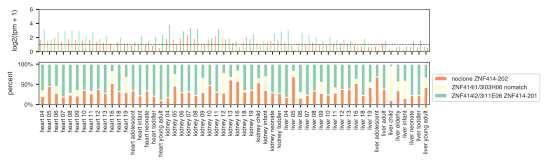

In [192]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "median" not in x]
notestis_cols = [x for x in notestis_cols if "max" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("ZNF414", (7, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

In [202]:
pd.DataFrame(f_dev.loc["ZNF414|1/3|03H06 nomatch"]).sort_values(by="ZNF414|1/3|03H06 nomatch", ascending=False).head(10)

,ZNF414|1/3|03H06 nomatch
max,83.452754
liver child,83.452754
hindbrain adult,62.138085
ovary 16,51.006149
kidney 12,48.529911
forebrain adult,45.667699
ovary 11,45.295546
testis 09,45.036252
liver infant,44.383024
hindbrain child,40.176204


In [186]:
"noclone ZSCAN9-208".split(" ")[1]

'ZSCAN9-208'